# Parte 6

Algoritmo FFT, Fast Fourier ransform e sue applicazioni nell'elaborazione di segnali e immagini.

## Funzione box

Teoria dei segnali,

     f = box(t, A,  B)

A e B sono gli estremi in cui box è non nulla.

In [1]:
function f = boxf(t, a, b)

f = zeros(size(t));
% si estraggono i valori di t in [A,B]
indici = t >= a & t <= b; 

% si impone che la funzione abbia valore unitario
f(indici) = 1;

end

## Esercizio 1

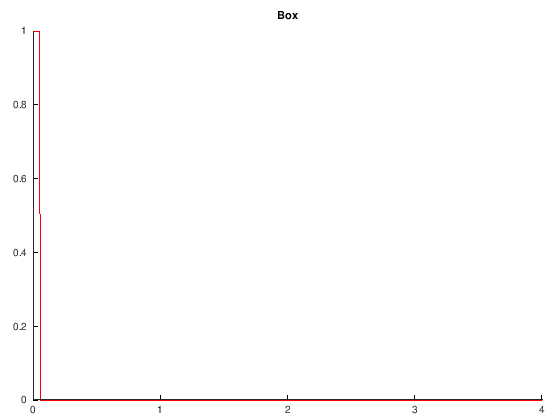

In [2]:
dt = 0.01; % pass di campionamento nel dominio reale (distanza tra due campioni)
t = 0.01; % pass di campionamento nel dominio reale (distanza tra due campioni)
fs = 1/dt; % frequenza di campionamento (numero di campioni raccolti al secondo) [Hz]

durata_segnale = 4;
durata_box = 0.05; % regola dilatazione e restingimento
t = (0:dt:durata_segnale); % campionamento

a = 0; b = durata_box;
f_box = boxf(t, a, b);
N = length(t);

figure
plot(t, f_box, 'r');
title('Box');
box off;

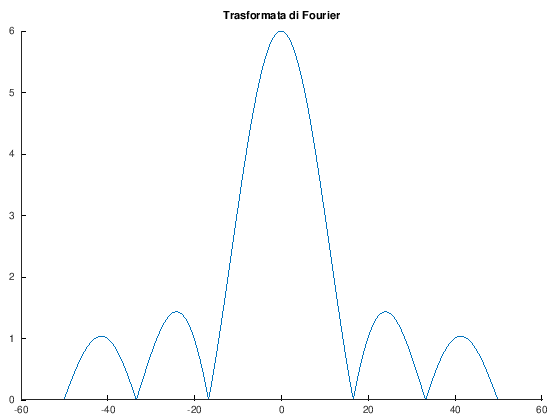

In [3]:
% Trasformata di Fourier discreta con shift di frequenza
% gli elementi dell'array a frequenza zero sono posti al centro dell'array
tr = fftshift(fft(f_box));

delta_u = 1 / (N * dt);
u = (- fs / 2 : delta_u : fs / 2 - delta_u);

figure
plot(u, abs(tr)) % abs di un numero complesso dà il modulo del numero complesso
title("Trasformata di Fourier");
box off

L'alterazione della durata della box permette di dimostrare intuitivamente la scalatura del dominio reale.

## Esercizio 2

In [4]:
clearvars
close all

fs = 350; % frequenza di campionamento (numero di campioni raccolti al secondo) [Hz]
dt = 1/fs; % pass di campionamento nel dominio reale (distanza tra due campioni)
durata_segnale = 4;
t = (0:dt:durata_segnale); % campionamento
N = length(t);

% funzione generatrice del primo segnale
f_box = 2 * sin(2 * pi * 15 * t) + 3 * sin(2 * pi * 60 * t);

% funzione generatrice del segnale perturbato
fbox_p = f_box + 0.5 * sin(2 * pi * 150 * t);

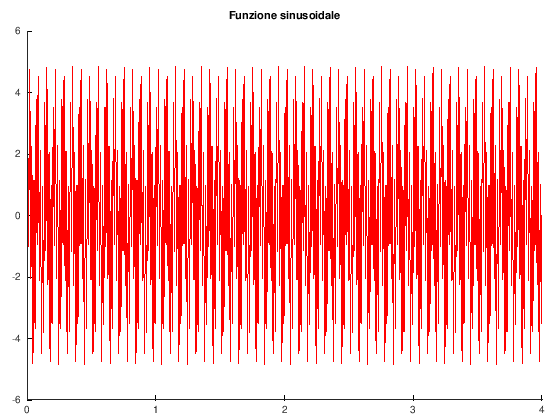

In [5]:
figure
plot(t, f_box, 'r');
title("Funzione sinusoidale");
box off

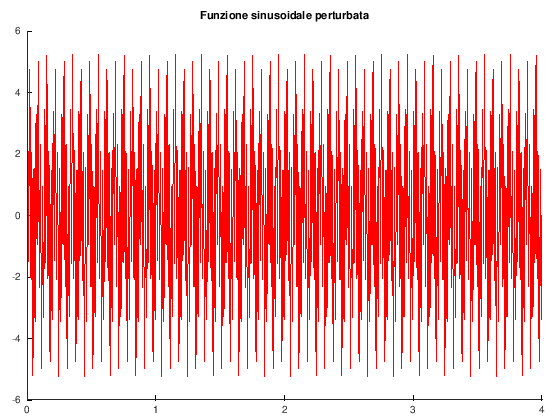

In [6]:
figure
plot(t, fbox_p, 'r');
title("Funzione sinusoidale perturbata");
box off

In [7]:
% calcolo della trasformata di Fourier
tr = fftshift(fft(f_box));
tr_p = fftshift(fft(fbox_p));

% Passaggio al dominio delle frequenze
delta_u = 1 / (N * dt); % passo di campionamento nel dominio di Fourier
u = (-fs/2:delta_u:fs/2- delta_u); %costruzione vettore delle frequenze

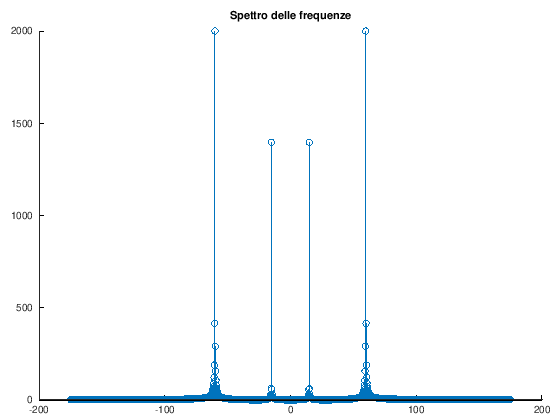

In [8]:
figure
% abs di un numero complesso dà il modulo del numero complesso
stem(u, abs(tr));
title("Spettro delle frequenze");

Lo spettro delle frequenze perturbato mostra la presenza di una frequenza a 150 Hz che non dovrebbe essere presente. Si opera una ripulitura del segnale.

In [9]:
% si annullano le frequenze che risultano in modulo maggiori di ftaglio
ftaglio = 70;
f_box_denoise = (abs(u) <= ftaglio).* fbox_p; 

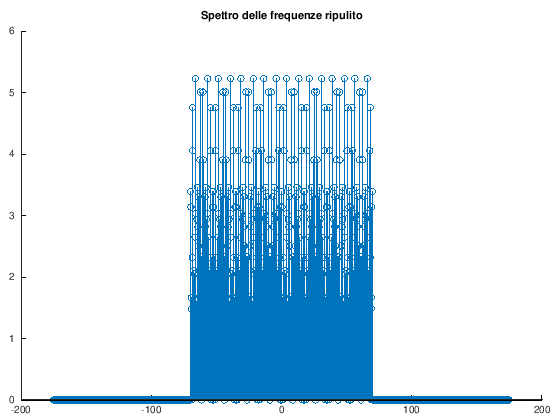

In [10]:
figure; 
stem(u, abs(f_box_denoise));
title("Spettro delle frequenze ripulito");

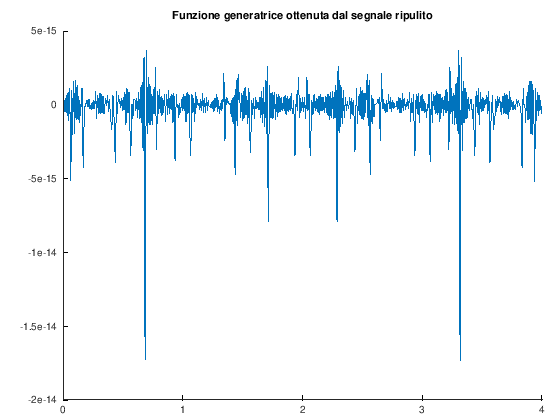

In [11]:
% verifica della corretta ricostruzione della funzione generatrice
ricostr = ifft(ifftshift(f_box_denoise));

figure; 
plot(t, real(ricostr));
title("Funzione generatrice ottenuta dal segnale ripulito");
box off

## Esercizio 3

A partire dal file audio `obo-c.wav` fornito, si aggiunga al segnale una frequenza di disturbo tramite una funzione sinusoidale di ampiezza 0.05 e frequenza 7500 Hz. Si effettui la ripulitura del segnale tramite un apposito filtro di Fourier di dimensione adeguata.

In [12]:
clearvars

% restituisce una matrice di uint8 e la frequenza di campionamento
[f, fs] = audioread("resources/obo-c.wav"); 
fprintf("sampling frequency:\t %.2f Hz\n", fs);

% numero campioni totale
num_samp = length(f);
durata = num_samp / fs;
fprintf("signal length: \t\t %f s\n", durata);

% passo di campionamento (periodo T)
period = 1 / fs;
xx = 0 : period : durata - period;

% frequenza di disturbo
fp = f + 0.05 * sin(2 * pi * 7500 * xx');

sampling frequency:	 44100.00 Hz
signal length: 		 1.697959 s


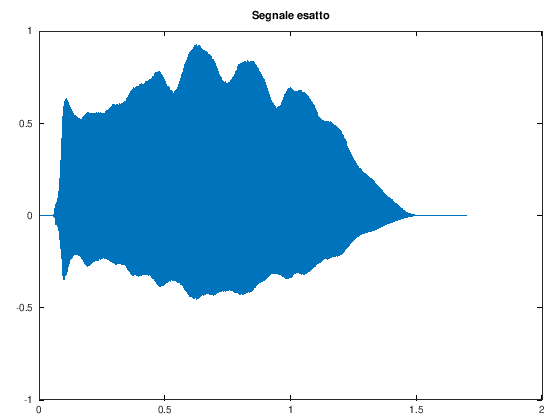

In [13]:
figure
plot(xx, f);
title("Segnale esatto");

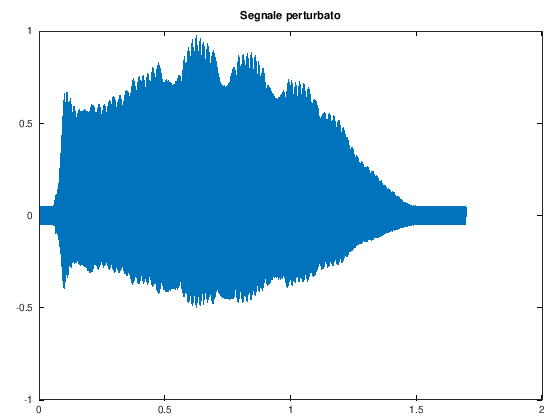

In [14]:
figure
plot(xx, fp);
title("Segnale perturbato");

In [36]:
% Ricostruzione del segnale audio tramite filtro di Fourier

%{
1. Si calcola la trasformata di Fourier con shift del dominio
delle frequenze. La frequenza 0-esima al centro.
%}
tr_fourier = fftshift(fft(fp));

%{
2. Determinazione della frequenza di campionamento nel dominio di Fourier.

Per il teorema di Nyquist la frequenza di campionamento nel dominio
di Fourier deve essere il doppio della frequenza di campionamento nel
dominio reale. Perciò il range di frequenze è [-fs/2, +fs/2].
%}
samp_freq = fs / num_samp;
xx_freq = (-fs/2 : samp_freq : fs/2 - samp_freq)';

%{
3. Ricostruzione del segnale con applicazione di un filtro passa basso
Si annullano nella trasformata di Fourier dell'immagine tutte le frequenze che
stanno fuori dal vettore delle frequenze non filtrate, facendo una moltiplicazione 
point-wise tra i valori della trasformata di Fourier ed il filtro_PB;
%}

f_t = tr_fourier.*(abs(xx_freq) <= 800); % filter defined on demand
restored = ifft(ifftshift(f_t));

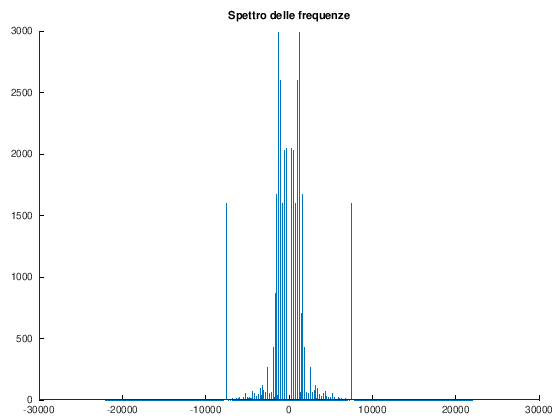

In [37]:
figure
plot(xx_freq, abs(tr_fourier)); 
title("Spettro delle frequenze");
box off

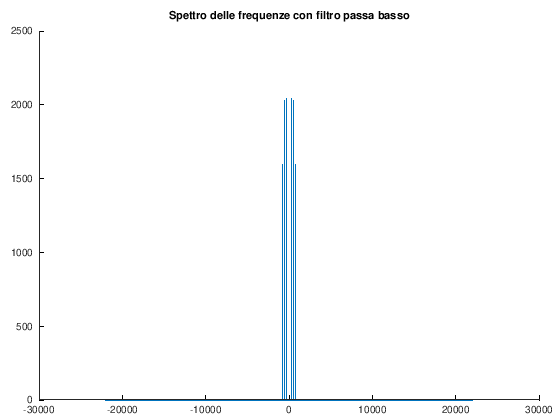

In [38]:
figure
plot(xx_freq, abs(f_t));
title("Spettro delle frequenze con filtro passa basso");
box off

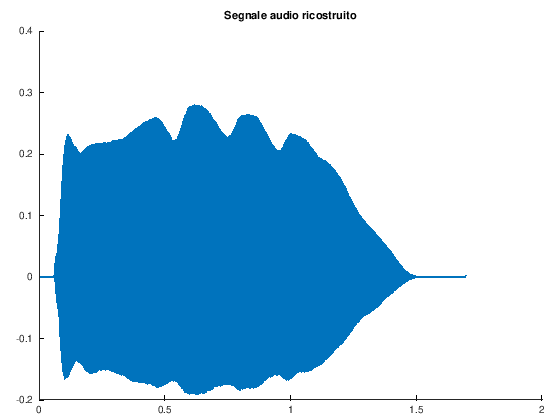

In [18]:
figure
plot(xx, real(restored));
title("Segnale audio ricostruito");
box off

In [19]:
% riproduzione audio originale
%sound(f, fs); 

% riproduzione audio corrotto
%sound(fp, fs);

% riproduzione audio ripulito
%sound(real(restored), fs);

## Esercizio 4

A partire dall'immagine `cameraman.png` fornita, si implementi un filtro passa basso e un filtro passa alto di dimensione variabile per effettuare il filtraggio dell'immagine.

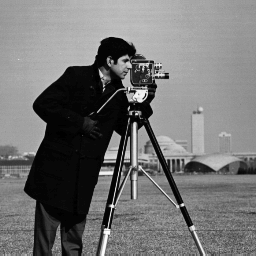

In [20]:
im = imread("resources/cameraman.png"); % immagine come matrice di uint8

figure
imshow(im);

In [21]:
im = double(im); % cast a double richiesto per l'elaborazione (im(:,:,1))

[w,h] = size(im);
fprintf("Dimensione immagine %d x %d\n",w, h);

Dimensione immagine 256 x 256


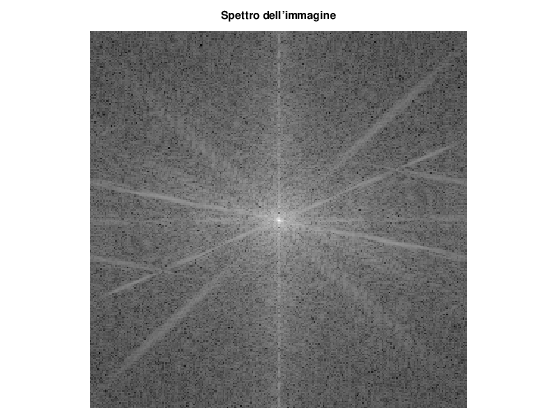

In [22]:
trasf = fftshift(fft2(im));
figure
imshow((log(1 + abs(trasf))), []); % si aggiunge 1 per evitare logaritmi nulli
title("Spettro dell'immagine")

Raggio del filtro (positivo e minore della dimensione dell'immagine fratto due) 12


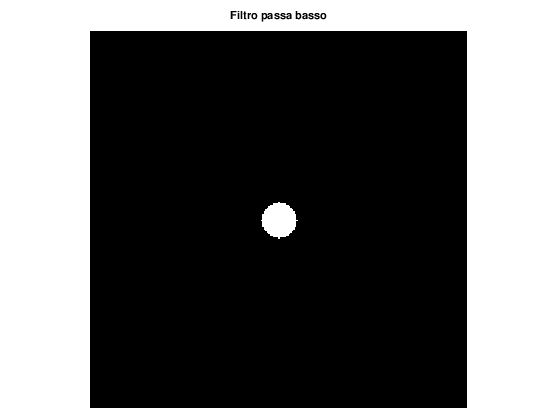

In [23]:
% calcolo centro dell'immagine
yc = floor(w / 2) + 1;
xc = floor(h / 2) + 1;

raggio = input(
    "Raggio del filtro (positivo e minore della dimensione dell'immagine fratto due)");

% inizializzazione del filtro passa basso
filtro_PB = ones(w,h);

for m=1:w
   for l=1:h
       % calcolo distanza del punto (m,l) della matrice dal centro
       d = sqrt((xc - l).^2 + (yc - m).^2);

       % tutti i punti esterni al cerchio non formano il filtro e vanno
       % inizializzati a zero
       if d > raggio
           filtro_PB(m,l) = 0;
       end
   end
end

figure
imshow(filtro_PB)
title('Filtro passa basso')

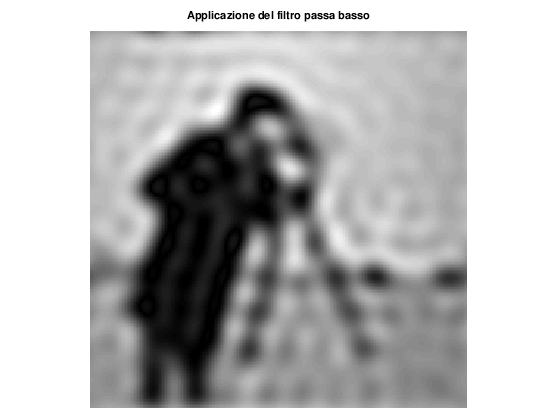

In [24]:
%{
Si annullano nella trasformata di Fourier dell'immagine tutte le frequenze che
stanno fuori dal cerchio, facendo una moltiplicazione point-wise tra i
valori della trasformata di Fourier ed il filtro_PB;
%}
           
trasf_PB = trasf.* filtro_PB;

% Si calcola la trasformata di Fourier inversa a partire 
% dalla trasformata di Fourier filtrata con il filtro passa basso             

Im_PB = ifft2( ifftshift(trasf_PB) );

figure
imshow(abs(Im_PB),[])
title('Applicazione del filtro passa basso')

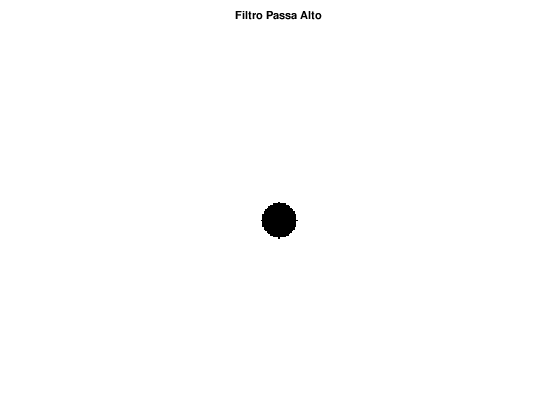

In [25]:
% il filtro passa alto è l'inverso del passa basso
filtro_PH = 1 - filtro_PB;
figure
imshow(filtro_PH)
title("Filtro Passa Alto")

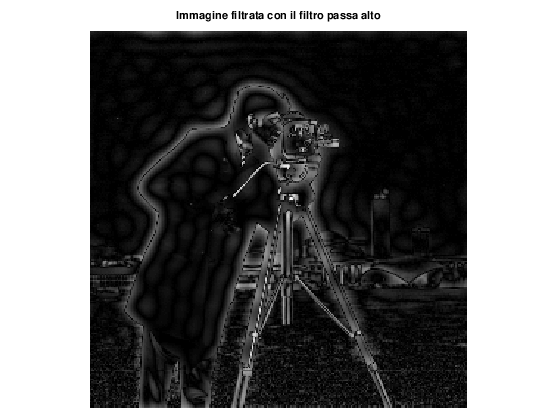

In [26]:
%{
Si annullano nella trasformata di Fourier dell'immagine tutte le
frequenze basse che stanno dentro il cerchio, facendo una
moltiplicazione point-wise tra i valori della trasformata di
Fourier ed il filtro_PH 
%}

trasf_PH=trasf.*filtro_PH;
Im_PH=ifft2(ifftshift(trasf_PH));
figure
imshow(abs(Im_PH),[])
title("Immagine filtrata con il filtro passa alto")